## Import libraries and read data

In [11]:
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from sklearn.preprocessing import StandardScaler

# RDKit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdFingerprintGenerator, rdMolDescriptors, AllChem
from rdkit.Chem import PandasTools, rdDepictor, rdFMCS
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles, MakeScaffoldGeneric


# tqdm
from tqdm.auto import tqdm

In [2]:
# enable tqdm into pandas
tqdm.pandas()

Load FDA approved drugs

In [3]:
HERE = Path(_dh[-1])
DATA_FOLDER = HERE.parent.parent/'data/fda_approved_datasets/'

fda_drugs = pd.read_csv(DATA_FOLDER/'fda_approved_drugs.csv')
fda_drugs.head(3)

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,natural_product_flag,oral,parenteral,topical
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,False,True,False,False
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,False,True,False,False
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,False,True,False,False


## Bemis-Murcko Scaffold

In [5]:
fda_drugs['framework'] = fda_drugs.clean_smiles.progress_apply(MurckoScaffoldSmilesFromSmiles)

  0%|          | 0/1895 [00:00<?, ?it/s]

In [12]:
def make_generic(smiles):
    return Chem.MolToSmiles(MakeScaffoldGeneric(Chem.MolFromSmiles(smiles)))

In [13]:
fda_drugs['generic_scaffold'] = fda_drugs.framework.progress_apply(make_generic)

  0%|          | 0/1895 [00:00<?, ?it/s]

In [21]:
scaffold_df = fda_drugs.generic_scaffold.value_counts().reset_index().copy() # cool trick
scaffold_df = scaffold_df[scaffold_df['generic_scaffold'] != ''].reset_index(drop=True).copy() # remove the error scaffolds
scaffold_df

,generic_scaffold,count
0,C1CCCCC1,200
1,CC1CCC2C(CCC3C4CCCC4CCC23)C1,81
2,C1CCC(CC2CCCCC2)CC1,52
3,C1CCC(C2CCCCC2)CC1,26
4,C1CCCC1,25
...,...,...
799,C1CCC(C(CCC2CCCC2)CC2CCCC2)CC1,1
800,C1CCC(CCC2CCC3CC(CC4CCCCC4)CCC23)CC1,1
801,CC1CCC2C(CCCCCC3CCCCC3)CCCC2C1,1
802,C1CCC(C2(CCCCC3CCCC3)CCCC3(CCCC3)C2)CC1,1


In [51]:
sum(scaffold_df['count'].to_list()[0:30])/sum(scaffold_df['count'].to_list())

0.37133370226895407

In [22]:
scaffold_df['mol'] = scaffold_df.generic_scaffold.progress_apply(Chem.MolFromSmiles)

  0%|          | 0/804 [00:00<?, ?it/s]

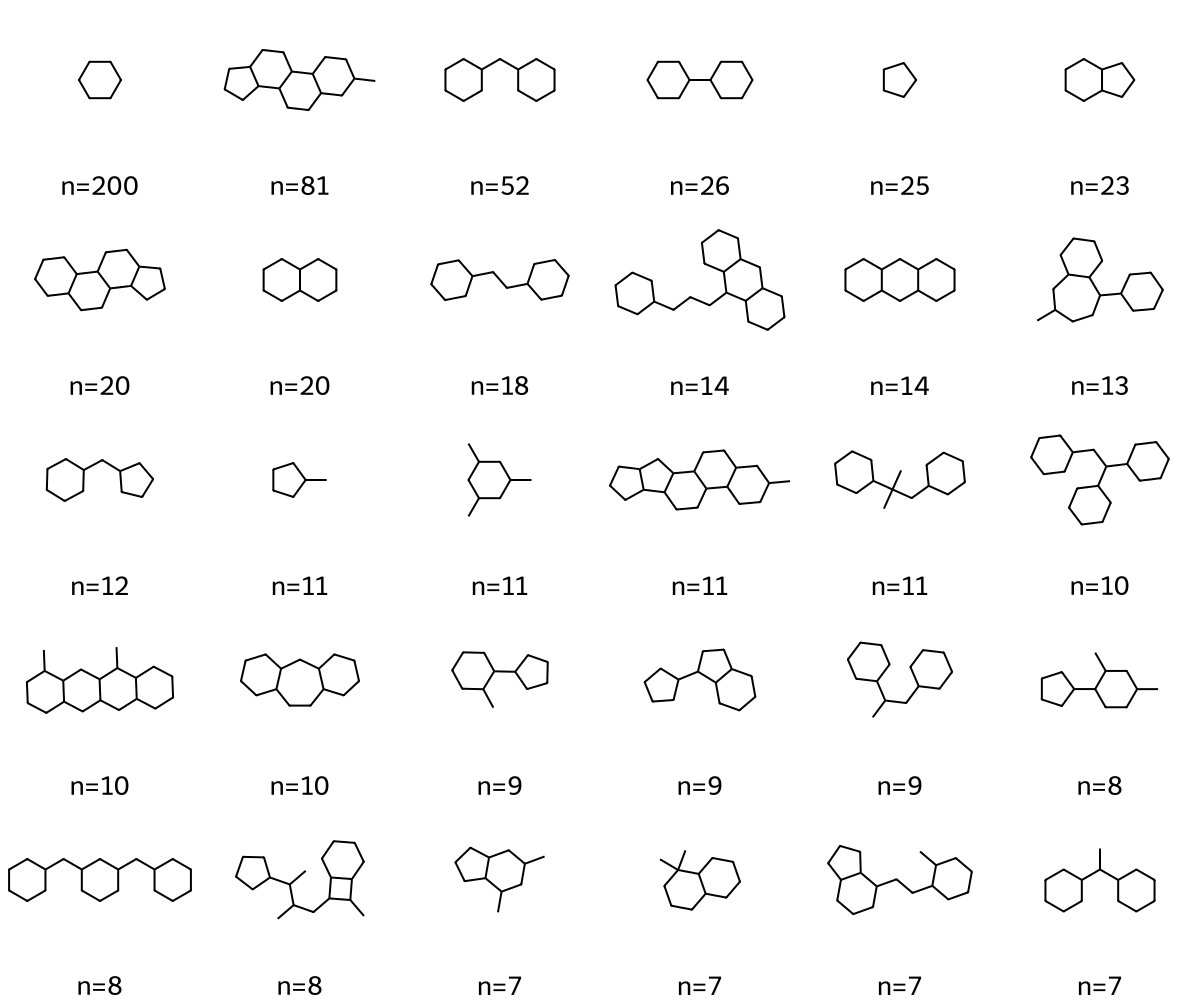

In [60]:
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.fixedFontSize = 22
IPythonConsole.drawOptions.legendFraction = 0.2
IPythonConsole.drawOptions.legendFontSize = 26
legends = scaffold_df['count'].to_list()
legends = [f'n={x}' for x in legends]
Draw.MolsToGridImage(
    mols =scaffold_df.mol[0:30],
    molsPerRow=6,
    legends=legends[0:30]
)